In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from typing import List, Dict
import time

# Compiling block

In [2]:
class ClogParser:
    def __init__(self, exe_path: str, args: List[str], makefile_dir: str = None):
        self.exe_path = exe_path
        self.args = args
        self.makefile_dir = makefile_dir or os.path.dirname(exe_path)

    def compile(self) -> None:
        print("🔧 Compiling with make...")
        start = time.time()
        result = subprocess.run(["make","pull"], cwd=self.makefile_dir, capture_output=True, text=True)
        end = time.time()
        if result.returncode != 0:
            print("❌ Make failed!\n", result.stderr)
            raise RuntimeError("Compilation failed.")
        print(f"✅ Compilation successful for {end - start}s.")

    def run(self):
        print("🔧 Running it...")
        start = time.time()
        result = subprocess.run([self.exe_path] + self.args, capture_output=True, text=True)
        end = time.time()
        if result.stderr:
            print("Execution stderr:\n", result.stderr)
        print(f"✅ Done running for {end - start}s.")
        return result.stderr, result.stdout

    def parse_monitoring_lines(self, logs: str):
        pattern = re.compile(
            r"algo=(?P<algo>\w+)?\s*"
            r"avg_insert_time=(?P<insert_time>[\d.:]+)\s*"
            r"avg_test_time=(?P<test_time>[\d.:]+)\s*"
            r"filter=(?P<filter>[\w\s]+)\s*"
            r"fp_log=(?P<fp_log>\([^)]+\)(?:\([^)]+\))*)?\s*"
            r"id=(?P<id>\d+)\s*"
            r"memory=(?P<memory>[\d.]+)\s*"
            r"scheme=(?P<scheme>[\w-]+)?"
        )

        entries = []
        for line in logs.splitlines():
            line = line.strip()
            if not line.startswith("[MONITOR]"):
                continue
            match = pattern.search(line)
            if match:
                data = match.groupdict()

                # Handle insert/test time
                def parse_time(raw):
                    parts = list(map(float, raw.split(":")))
                    result = parts[0]
                    for divisor in parts[1:]:
                        result /= divisor
                    return result * 1e6  # microseconds for better scale

                insert_time = parse_time(data["insert_time"]) if data["insert_time"] else 0
                test_time = parse_time(data["test_time"]) if data["test_time"] else 0

                # Parse fp_log
                fp_log = []
                if data["fp_log"] and data["fp_log"] != "all 1":
                    for m in re.findall(r"\((\d+),(\d+),(\d+)\)", data["fp_log"]):
                        num_fp, num_added, num_tested = map(int, m)
                        false_rate = num_fp / num_tested if num_tested > 0 else 0
                        fp_log.append({
                            "num_fp": num_fp,
                            "num_added": num_added,
                            "num_tested": num_tested,
                            "false_rate": false_rate
                        })

                entries.append({
                    "algo": data.get("algo", "BinarySearch"),
                    "filter": data["filter"].strip(),
                    "insert_time": insert_time,
                    "test_time": test_time,
                    "fp_log": fp_log
                })
        return entries
    
    def parse_monitor_logs_to_df(self, logs: str) -> pd.DataFrame:
        parsed = self.parse_monitoring_lines(logs)
        df = pd.DataFrame([
            {
                "algo": e["algo"],
                "filter": e["filter"],
                "insert_time": e["insert_time"],
                "test_time": e["test_time"],
                "fp_log": e["fp_log"]
            }
            for e in parsed
        ])
        return df


In [ ]:
exe = "D:/Desktop/csbf/main.exe"
args = []
make_dir = "D:/Desktop/csbf"  # your Makefile directory

parser = ClogParser(exe_path=exe, args=args, makefile_dir=make_dir)
parser.compile()
monitors, logs = parser.run()

🔧 Compiling with make...
✅ Compilation successful for 6.1073596477508545s.
🔧 Running it...


In [ ]:
df = parser.parse_monitoring_lines(monitors)
# df.loc[66:70, 'Filter'] = 'MergableCBF'
# df.loc[46:65, 'Filter'] = 'MergeableFilter'

df.head()

,accuracy,AddOrRemoveTime,HashAlgo,false_positives,Filter,FilterID,memory,MergeTime,HashScheme,TestTime
0,0.969606,1.968278,murmur3_128,30394,OHBF,1747281019668,7760935.0,0.0,kir-mitz,3.350293
1,0.969915,4.208799,sha256,30085,OHBF,1747281024965,7760935.0,0.0,kir-mitz,9.584741
2,0.999200,2.462066,murmur3_128,800,DelBF,1747281036504,11641402.0,0.0,kir-mitz,4.629934
3,0.999174,5.064837,sha256,826,DelBF,1747281042531,11641402.0,0.0,kir-mitz,11.606160
4,0.999193,2.027105,murmur3_128,807,StdBF,1747281055746,7760935.0,0.0,kir-mitz,4.602015


# Visualization block

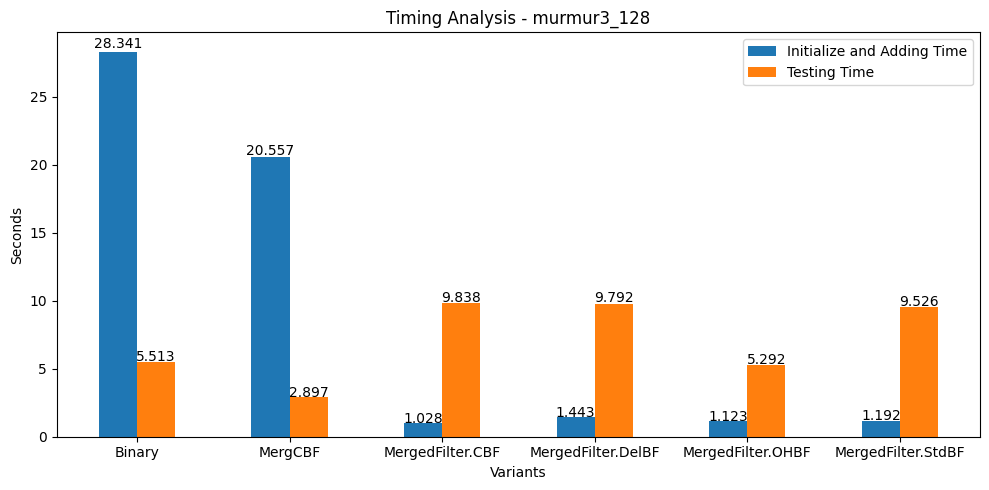

[INFO] No time data for HashAlgo = sha256
[INFO] No time data for HashAlgo = nan


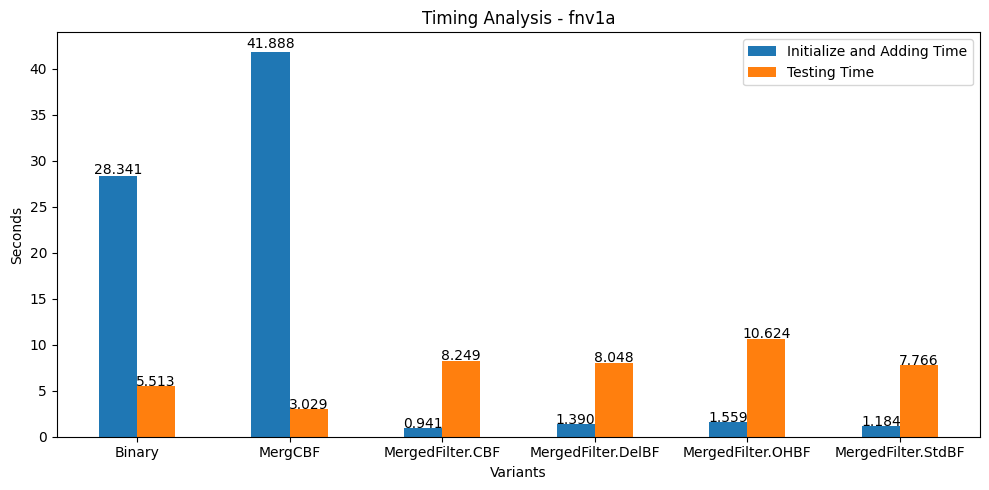

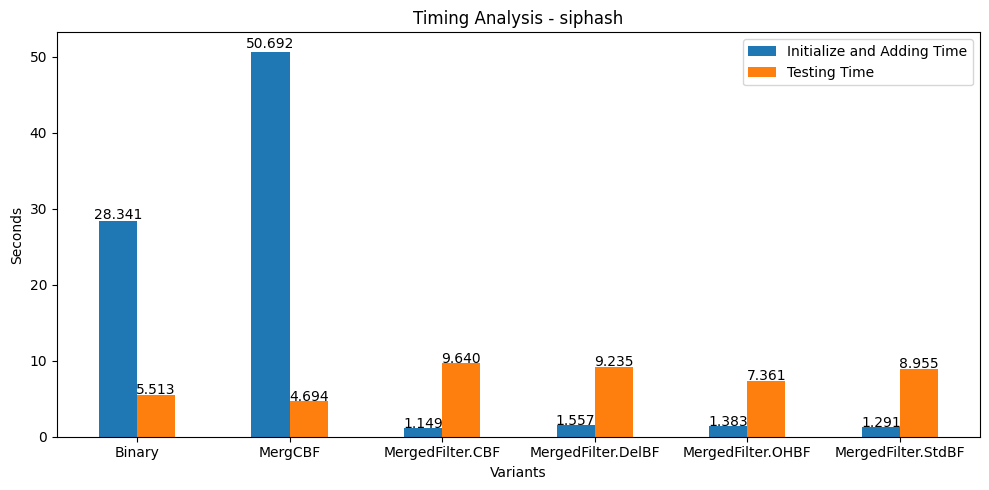

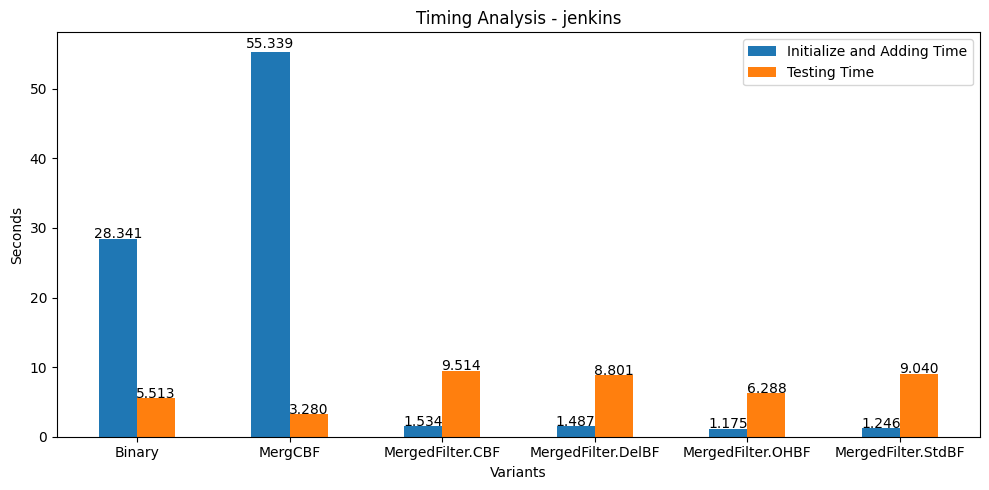

In [ ]:
class PerformanceVisualizer:
    def __init__(self, df: pd.DataFrame, prefix: str = ""):
        self.isMakingEps = True
        self.isMakingEps = False
        self.png_dpi = 1000
        self.df = df
        self.prefix = prefix
        
    def hashes(self) -> List[str]:
        # Extract unique hash schemes and algorithms
        hash_algos = self.df["HashAlgo"].unique()
        return list(hash_algos)
    
    def plot_avg_times(self, df: pd.DataFrame):
        for algo in df["algo"].unique():
            sub_df = df[df["algo"] == algo].copy()

            labels = sub_df["filter"].tolist()
            insert = sub_df["insert_time"]
            test = sub_df["test_time"]

            x = np.arange(len(labels))
            width = 0.35

            fig, ax = plt.subplots(figsize=(8, 4))
            ax.bar(x - width/2, insert, width, label="Insert")
            ax.bar(x + width/2, test, width, label="Test")

            ax.set_ylabel("Time (s)")
            ax.set_title(f"Insert vs Test Time: {algo}")
            ax.set_xticks(x)
            ax.set_xticklabels(labels)
            ax.legend()

            plt.tight_layout()
            plt.show()

    def plot_fp_logs(self, df: pd.DataFrame):
        for algo in df["algo"].unique():
            sub_df = df[df["algo"] == algo].copy()

            fig, ax1 = plt.subplots(figsize=(8, 5))
            ax2 = ax1.twinx()

            for _, row in sub_df.iterrows():
                x = [point["added"] for point in row["fp_log"]]
                y_fp = [point["fp"] for point in row["fp_log"]]
                y_rate = [point["fp"] / point["tested"] for point in row["fp_log"]]

                ax1.plot(x, y_fp, marker="o", label=f"{row['filter']} (FP count)")
                ax2.bar(x, y_rate, alpha=0.3, label=f"{row['filter']} (FP rate)")

            ax1.set_xlabel("Items Added")
            ax1.set_ylabel("False Positives Count")
            ax2.set_ylabel("False Positive Rate")
            ax1.set_title(f"False Positive Analysis - {algo}")

            fig.legend(loc="upper right")
            plt.tight_layout()
            plt.show()

    def plot_memory_usage(self, df: pd.DataFrame):
        fig, ax = plt.subplots(figsize=(8, 4))
        df["memory_kb"] = df["memory"] / 1024

        ax.bar(df["filter"], df["memory_kb"])
        ax.set_ylabel("Memory (KB)")
        ax.set_title("Memory Usage by Filter")
        plt.tight_layout()
        plt.show()
    
visualizer = PerformanceVisualizer(df,'bus')
visualizer.plot_avg_times(df)
visualizer.plot_fp_logs(df)



# Bus UC

### Time

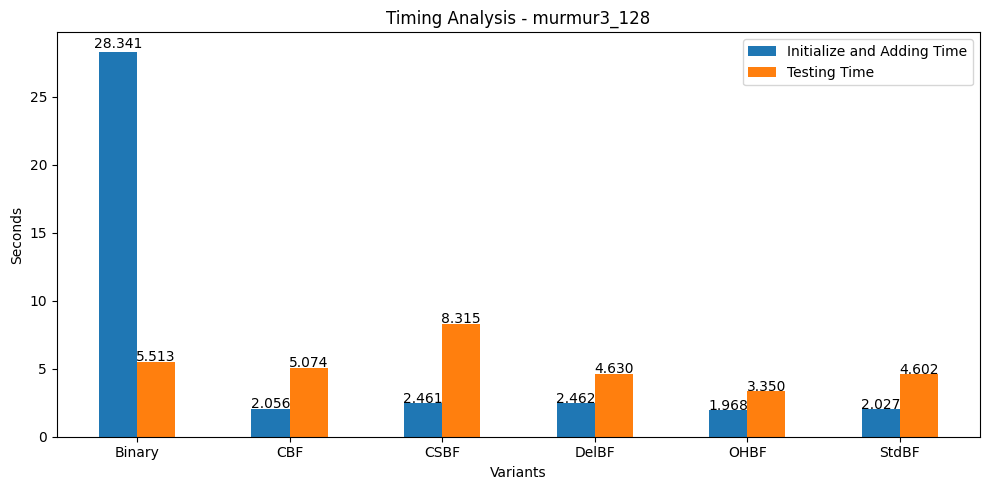

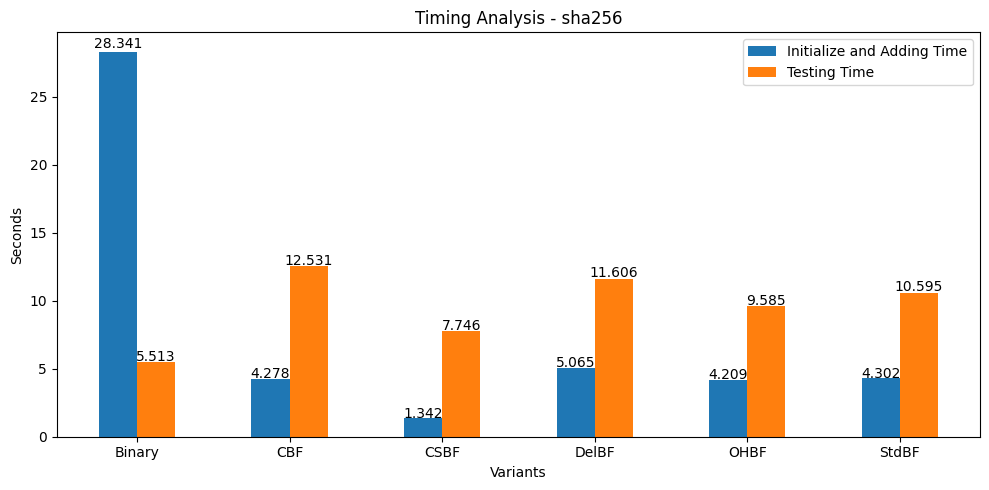

[INFO] No time data for HashAlgo = nan
[INFO] No time data for HashAlgo = fnv1a
[INFO] No time data for HashAlgo = siphash
[INFO] No time data for HashAlgo = jenkins


In [ ]:
# bus_targets = [
#     "OHBF",
#     "DelBF",
#     "StdBF",
#     "CBF",
#     "CSBF",
#     "Binary",
# ]
# visualizer = PerformanceVisualizer(df,'bus')
# visualizer.time_analysis_plot(bus_targets)

# ### Accuracy 
# visualizer.analyze_accuracy_plot(bus_targets)

# ### Memory
# visualizer.analyze_memory_plot(bus_targets)

# Bank UC

In [ ]:
# bank_targets = ["MergedFilter.DelBF", "MergedFilter.StdBF", "MergedFilter.CBF", "MergedFilter.OHBF", "MergCBF", "Binary"] 
# visualizer = PerformanceVisualizer(df,'bank')
# visualizer.time_analysis_plot(bank_targets)

# ### Accuracy
# visualizer.analyze_accuracy_plot(bank_targets)

# ### Memory
# visualizer.analyze_memory_plot(bank_targets)